<a href="https://colab.research.google.com/github/AjibolaPy/unet/blob/server1/brain_tumor_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import random
import skimage
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import itertools
import seaborn as sns
from glob import glob
from tqdm import tqdm
from tensorflow.keras import backend as K
#from tensorflow.keras.utils.np_utils import 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import sys
import pandas as pd
sys.path.append(os.path.abspath('/content/Unet Arch.py'))
sys.path.append(os.path.abspath('/content/'))
import Unet
from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)
#import VGGUNET

plt.style.use('dark_background')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install opendatasets  #b8c7ab494b731a816359feb7c8133e6b
import opendatasets
opendatasets.download('https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ajibolaemmanuel
Your Kaggle Key: ··········


100%|██████████| 714M/714M [00:05<00:00, 132MB/s]


In [7]:
df=pd.read_csv("lgg-mri-segmentation/kaggle_3m/data.csv")
df.isna().sum() 

Patient                       0
RNASeqCluster                18
MethylationCluster            1
miRNACluster                  0
CNCluster                     2
RPPACluster                  12
OncosignCluster               5
COCCluster                    0
histological_type             1
neoplasm_histologic_grade     1
tumor_tissue_site             1
laterality                    1
tumor_location                1
gender                        1
age_at_initial_pathologic     1
race                          2
ethnicity                     8
death01                       1
dtype: int64

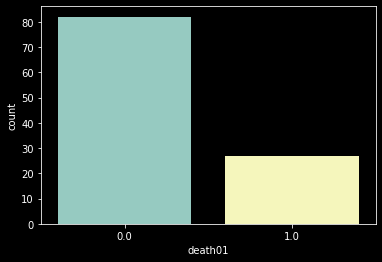

In [ ]:
sns.countplot(data=df, x='death01')

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
6,TCGA_CS_5396,3.0,3.0,2,3.0,2.0,2.0,3,3.0,2.0,1.0,3.0,2.0,1.0,53.0,3.0,2.0,0.0
8,TCGA_CS_6186,2.0,4.0,1,2.0,1.0,3.0,2,2.0,2.0,1.0,3.0,2.0,2.0,58.0,3.0,2.0,1.0
9,TCGA_CS_6188,2.0,4.0,3,2.0,3.0,3.0,2,1.0,2.0,1.0,3.0,6.0,2.0,48.0,3.0,2.0,0.0
11,TCGA_CS_6665,2.0,5.0,1,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,6.0,1.0,51.0,3.0,2.0,0.0
14,TCGA_CS_6668,3.0,2.0,2,3.0,2.0,1.0,3,3.0,1.0,1.0,1.0,2.0,1.0,57.0,3.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,TCGA_HT_8106,2.0,5.0,3,1.0,2.0,2.0,2,1.0,2.0,1.0,2.0,2.0,2.0,53.0,3.0,2.0,0.0
101,TCGA_HT_8107,4.0,1.0,1,1.0,4.0,3.0,1,3.0,1.0,1.0,1.0,5.0,2.0,62.0,3.0,2.0,0.0
102,TCGA_HT_8111,1.0,5.0,1,1.0,1.0,2.0,1,2.0,2.0,1.0,1.0,2.0,2.0,32.0,3.0,2.0,0.0
103,TCGA_HT_8113,4.0,3.0,1,1.0,4.0,1.0,1,3.0,1.0,1.0,1.0,2.0,1.0,49.0,2.0,2.0,0.0


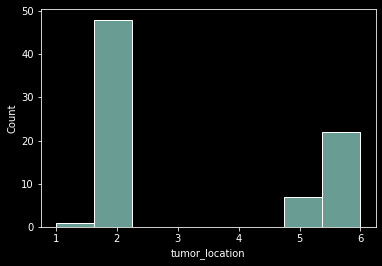

In [8]:
data=df.copy()
data.dropna(inplace=True)
sns.histplot(data=data, x=data['tumor_location'])
data

In [9]:
dara=pd.DataFrame()

In [10]:
mask_path=glob('lgg-mri-segmentation/kaggle_3m/*/*_mask.tif')
image_path=[i.replace('_mask', '') for i in mask_path]

dara['client_img_folder']=glob('lgg-mri-segmentation/kaggle_3m/*')
dataf=pd.concat([dara, df], axis=1)
dataf.head(3)




,client_img_folder,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19...,TCGA_CS_4941,2.0,4.0,2.0,2.0,NaN,3.0,2.0,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7301_19...,TCGA_CS_4942,1.0,5.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20...,TCGA_CS_4943,1.0,5.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0


In [11]:
im_msk=pd.DataFrame()

im_msk['image_path']=image_path
im_msk['mask_path']=mask_path

In [ ]:
im_msk

,image_path,mask_path
0,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19...
1,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19...
2,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19...
3,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19...
4,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19...
...,...,...
3924,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19...
3925,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19...
3926,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19...
3927,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_7692_19...


In [12]:
def show_image():
    fig=plt.figure(figsize=(8,8))
    msks=[]
    imgs=[]
    for i in range(20):
        xx=random.randint(45, 2100)
        imgs.append(image_path[xx])
        msks.append(mask_path[xx])
    plt.suptitle('Image and Mask')
    fig=plt.figure(figsize=(60,60))
    fig.add_subplot(2,8,1)
    xx=random.randint(0, len(msks))
    plt.imshow(plt.imread(imgs[2]))
    fig.add_subplot(2,8,2)
    plt.imshow(plt.imread(msks[2]))
    fig.add_subplot(2,8,3)
    plt.imshow(plt.imread(imgs[1]))
    fig.add_subplot(2,8,4)
    plt.imshow(plt.imread(msks[1]))
    fig.add_subplot(2,8,5)
    plt.imshow(plt.imread(imgs[7]))
    fig.add_subplot(2,8,6)
    plt.imshow(plt.imread(msks[7]))
    fig.add_subplot(2,8,7)
    plt.imshow(plt.imread(imgs[10]))
    fig.add_subplot(2,8,8)
    plt.imshow(plt.imread(msks[10]))
  

<Figure size 576x576 with 0 Axes>

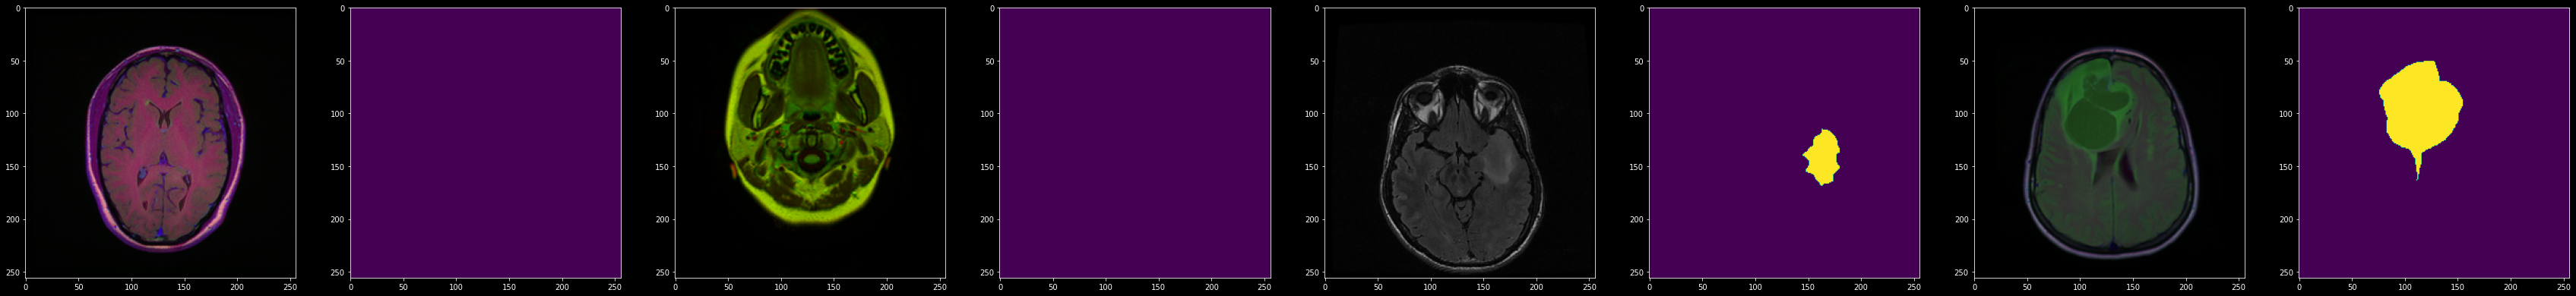

<Figure size 576x576 with 0 Axes>

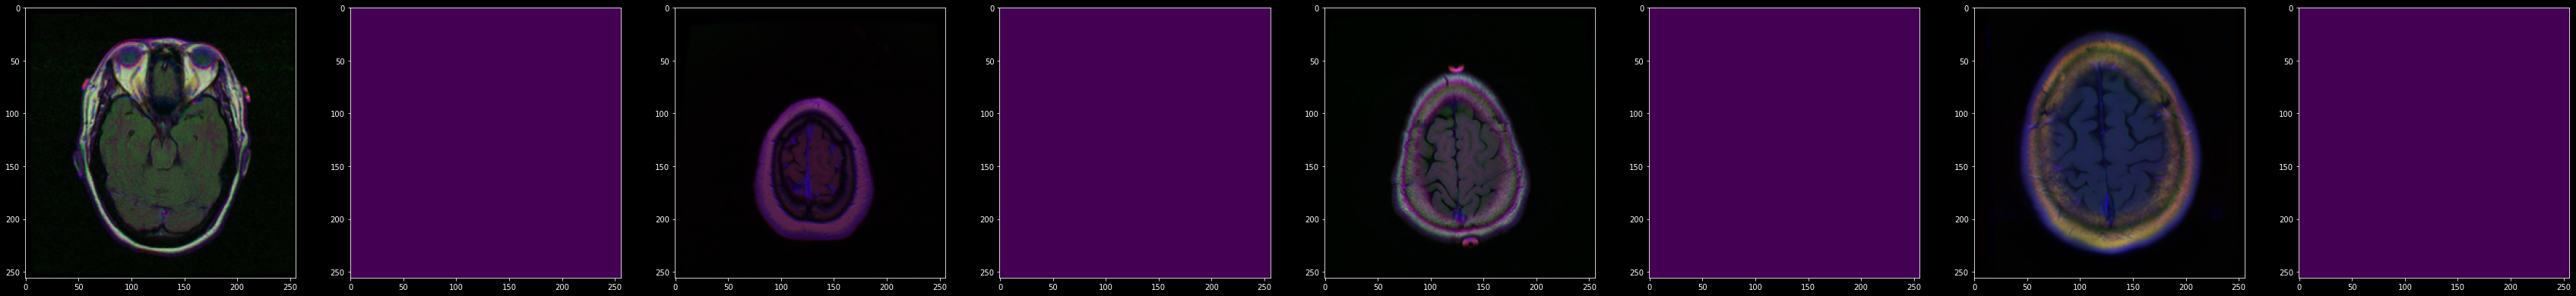

In [ ]:
for i in range(2):
    show_image()

In [13]:
train, test, train_label, test_label=train_test_split(im_msk.iloc[:,0], im_msk.iloc[:,1], test_size=0.1)
train=pd.DataFrame(train)
train_label=pd.DataFrame(train_label)
test, validation, test_label, validation_label=train_test_split(test, test_label, train_size=0.1)
test=pd.DataFrame(test)
test_label=pd.DataFrame(test_label)
validation=pd.DataFrame(validation)
validation_label=pd.DataFrame(validation_label)

In [14]:
def prep_mask(mask):
    if mask.max()!=0:
        mask=mask/mask.max()
    msk=cv2.resize(mask,(256, 256))
    msk=np.expand_dims(msk, axis=-1)
    return msk

def prep_img(img):
    img=img/img.max()
    img=cv2.resize(img, (256,256))
    return img




train_img_gen=ImageDataGenerator(preprocessing_function=prep_img)
train_images=train_img_gen.flow_from_dataframe(dataframe=train, x_col='image_path', batch_size=10, class_mode=None, seed=1)

train_mask_gen=ImageDataGenerator(preprocessing_function=prep_mask)
train_mask=train_mask_gen.flow_from_dataframe(dataframe=train_label,x_col='mask_path',batch_size=10,
                                 class_mode=None, seed=1, color_mode='grayscale')

validation_img_gen=ImageDataGenerator(preprocessing_function=prep_img)
val_images=validation_img_gen.flow_from_dataframe(dataframe=validation, x_col='image_path', batch_size=10, class_mode=None, seed=1)

valid_mask_gen=ImageDataGenerator(preprocessing_function=prep_mask)
valid_mask=valid_mask_gen.flow_from_dataframe(dataframe=validation_label,x_col='mask_path',batch_size=10,
                                 class_mode=None, seed=1, color_mode='grayscale')

test_img_gen=ImageDataGenerator(preprocessing_function=prep_img)
test_images=test_img_gen.flow_from_dataframe(dataframe=test, x_col='image_path', batch_size=10, class_mode=None, seed=1)

test_mask_gen=ImageDataGenerator(preprocessing_function=prep_mask)
test_mask=test_mask_gen.flow_from_dataframe(dataframe=test_label,x_col='mask_path',batch_size=40,
                                 class_mode=None, seed=1, color_mode='grayscale')


train_data=zip(train_images, train_mask)
valid_data=zip(val_images, valid_mask)
test_data=zip(test_images, test_mask)

Found 3536 validated image filenames.
Found 3536 validated image filenames.
Found 354 validated image filenames.
Found 354 validated image filenames.
Found 39 validated image filenames.
Found 39 validated image filenames.


(-0.5, 255.5, 255.5, -0.5)

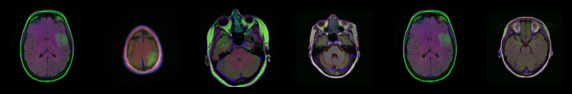

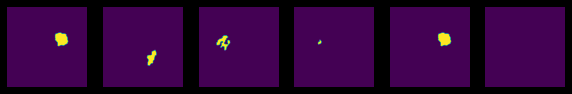

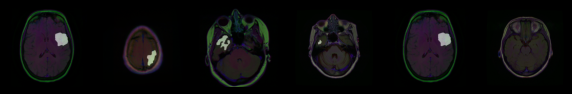

In [12]:
i, j=next(iter(train_data))

fig, ax=plt.subplots(1, 6, figsize=(10,10))

ax[1].imshow(i[1])
ax[1].axis('off')
ax[2].imshow(i[2])
ax[2].axis('off')
ax[3].imshow(i[3])
ax[3].axis('off')
ax[5].imshow(i[5])
ax[5].axis('off')
ax[4].imshow(i[7])
ax[4].axis('off')
ax[0].imshow(i[7])
ax[0].axis('off')

fig, ax=plt.subplots(1, 6, figsize=(10,10))

ax[1].imshow(np.squeeze(j[1]))
ax[1].axis('off')
ax[2].imshow(np.squeeze(j[2]))
ax[2].axis('off')
ax[3].imshow(np.squeeze(j[3]))
ax[3].axis('off')
ax[5].imshow(np.squeeze(j[5]))
ax[5].axis('off')
ax[4].imshow(np.squeeze(j[7]))
ax[4].axis('off')
ax[0].imshow(np.squeeze(j[7]))
ax[0].axis('off')

fig, ax=plt.subplots(1, 6, figsize=(10,10))

ax[1].imshow(i[1])
ax[1].axis('off')
ax[2].imshow(i[2])
ax[2].axis('off')
ax[3].imshow(i[3])
ax[3].axis('off')
ax[5].imshow(i[5])
ax[5].axis('off')
ax[4].imshow(i[7])
ax[4].axis('off')
ax[0].imshow(i[7])
ax[0].axis('off')

ax[1].imshow(np.squeeze(j[1]), alpha=0.5, cmap='gray')
ax[1].axis('off')
ax[2].imshow(np.squeeze(j[2]), alpha=0.5, cmap='gray')
ax[2].axis('off')
ax[3].imshow(np.squeeze(j[3]), alpha=0.5, cmap='gray')
ax[3].axis('off')
ax[5].imshow(np.squeeze(j[5]), alpha=0.5, cmap='gray')
ax[5].axis('off')
ax[4].imshow(np.squeeze(j[7]), alpha=0.5, cmap='gray')
ax[4].axis('off')
ax[0].imshow(np.squeeze(j[7]), alpha=0.5, cmap='gray')
ax[0].axis('off')





In [16]:
class display(Callback):
    def __init__(self, model, img, mask, img2, mask2):
        super(display).__init__()
        self.model=model
        self.img=img
        self.mask=mask
        assert self.img.shape[-1]==3, 'Your papa nono say e suppose be rgb image?'
        self.img=cv2.resize(self.img, (256, 256))
        self.img=self.img.reshape(1, 256, 256, 3)
        self.img2=img2
        self.mask2=mask2
        self.img2=self.img2.reshape(1, 256, 256, 3)
    def on_epoch_end(self,epochs, logs=None):
        print(f'On epoch {epochs}')
        pred=self.model.predict(self.img)
        pred=np.squeeze(pred)
        pred2=self.model(self.img2)

        plt.subplot(2,3,1)
        plt.axis('off')
        plt.imshow(pred, cmap='gray')
        plt.title('Prediction')
        plt.subplot(2,3,2)
        plt.axis('off')
        plt.title('Image')
        plt.imshow(np.squeeze(self.img))
        
        plt.subplot(2,3,3)
        plt.imshow(np.squeeze(self.mask), cmap='gray')
        plt.axis('off')
        plt.title('Mask')

        plt.subplot(2,3, 4)
        plt.title('Prediction')
        plt.imshow(np.squeeze(pred2), 'gray')
        plt.axis('off')
        plt.subplot(2,3, 5)
        plt.imshow(np.squeeze(self.img2))
        plt.axis('off')
        plt.subplot(2,3, 6)
        plt.title('Mask')
        plt.imshow(np.squeeze(self.mask2), cmap='gray')
        plt.axis('off')
        
        
        plt.show()
        
        


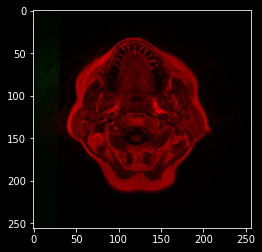

In [17]:
x,y=next(iter(valid_data))
plt.imshow(x[2])

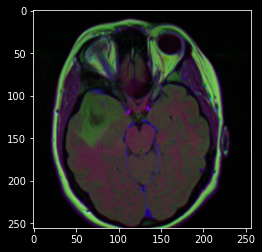

In [24]:
plt.imshow(x[3])

In [21]:
real_im=x[3]
pred_mask=y[3]

real2_im=x[2]
pred2_mask=y[2]


# USING VGG16-UNET ARCHITECTURE

In [20]:
#model=VGGUNET.model(1, activation='sigmoid')
model=Unet.Unet((256, 256, 3), 1)

In [ ]:
model2=resneet.resnet(1, 'sigmoid')

In [25]:
from keras.callbacks import ReduceLROnPlateau
opt=Adam(learning_rate=0.00001)
es=EarlyStopping(monitor='loss', mode='min', patience=10, restore_best_weights=True)
bm=ModelCheckpoint(filepath='/content/drive/MyDrive/brain_tumor1_segm.h5', monitor='loss', mode='min', save_best_only=True)
rl=ReduceLROnPlateau(monitor='loss', mode='min', factor=0.1, patience=3)
calls=[rl, es, bm, display(model, real_im, pred_mask, img2=real2_im, mask2=pred2_mask)]
ts=3536/18




def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + 100) / (sum_ - intersection + 100)
    return jac


Epoch 1/6
  6/196 [..............................] - ETA: 1:33 - loss: 0.0033 - accuracy: 0.9986 - iou: 0.7957

197/196 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9986 - iou: 0.7984On epoch 0


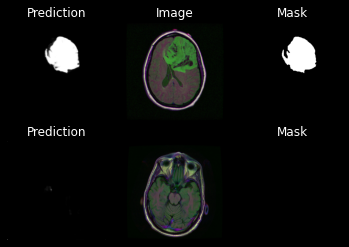

196/196 [==============================] - 105s 527ms/step - loss: 0.0034 - accuracy: 0.9986 - iou: 0.7984 - lr: 1.0000e-05
Epoch 2/6
197/196 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9986 - iou: 0.8079On epoch 1


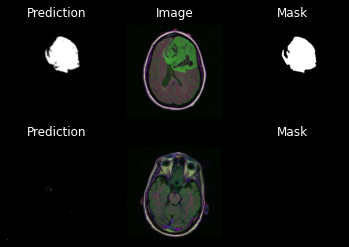

196/196 [==============================] - 103s 522ms/step - loss: 0.0033 - accuracy: 0.9986 - iou: 0.8079 - lr: 1.0000e-05
Epoch 3/6
197/196 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9986 - iou: 0.7973On epoch 2


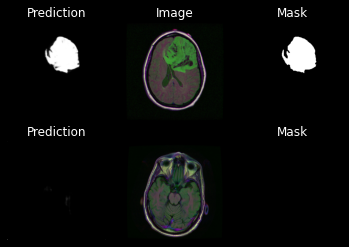

196/196 [==============================] - 99s 502ms/step - loss: 0.0034 - accuracy: 0.9986 - iou: 0.7973 - lr: 1.0000e-05
Epoch 4/6
197/196 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9986 - iou: 0.8157On epoch 3


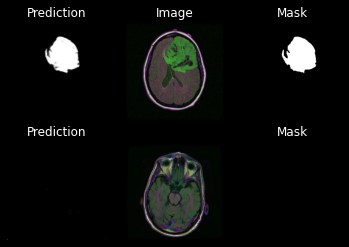

196/196 [==============================] - 98s 501ms/step - loss: 0.0033 - accuracy: 0.9986 - iou: 0.8157 - lr: 1.0000e-05
Epoch 5/6
197/196 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9987 - iou: 0.8107On epoch 4


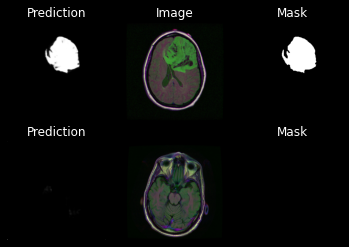

196/196 [==============================] - 102s 519ms/step - loss: 0.0032 - accuracy: 0.9987 - iou: 0.8107 - lr: 1.0000e-05
Epoch 6/6
197/196 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9986 - iou: 0.8071On epoch 5


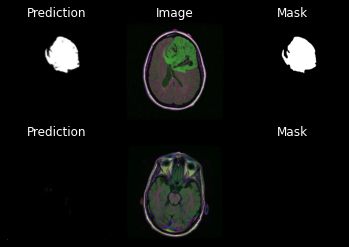

196/196 [==============================] - 99s 502ms/step - loss: 0.0033 - accuracy: 0.9986 - iou: 0.8071 - lr: 1.0000e-05


In [59]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', iou])

history=model.fit(train_data, batch_size=18, epochs=6, steps_per_epoch=ts, callbacks=calls)

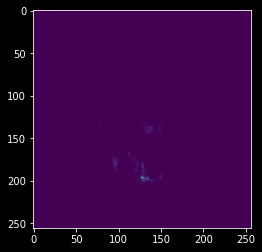

In [62]:
plt.imshow(np.squeeze(model.predict(np.expand_dims(x[9], axis=0))))

In [67]:
from random import randint

def show_img(inte):
  fig=plt.figure(figsize=(10,10))
  plt.subplot(1, 3, 1) 
  k=mo.predict(np.expand_dims(x[inte], axis=0))
  plt.title('Prediction')
  plt.imshow(np.squeeze(k), 'gray')

  plt.subplot(1, 3, 2)
  plt.title('Image')
  plt.imshow(x[inte])

  plt.subplot(1, 3, 3)
  plt.imshow(np.squeeze(y[inte]), 'gray')
  plt.title('Ground Truth')




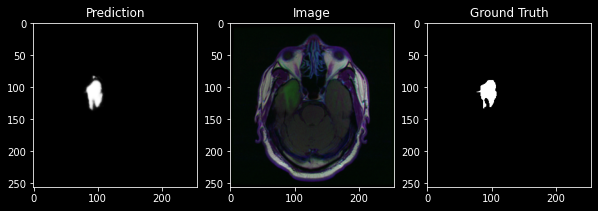

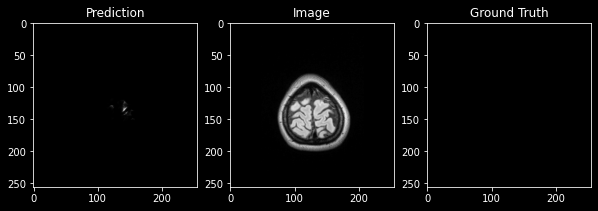

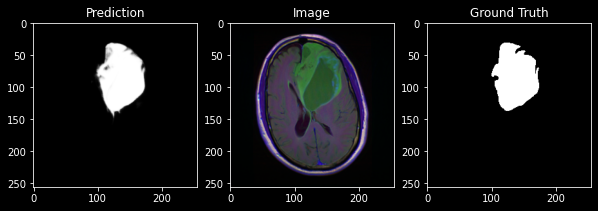

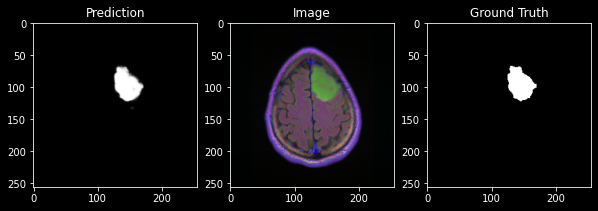

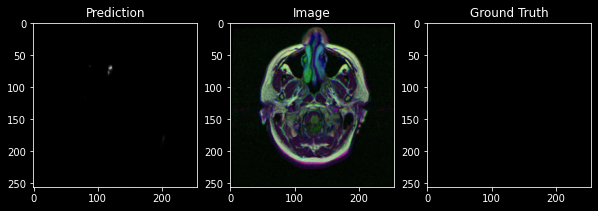

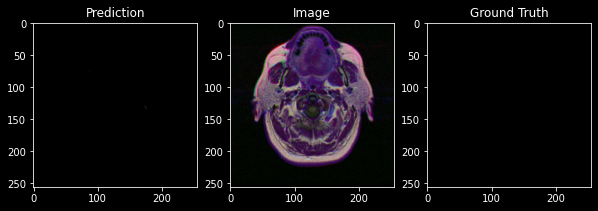

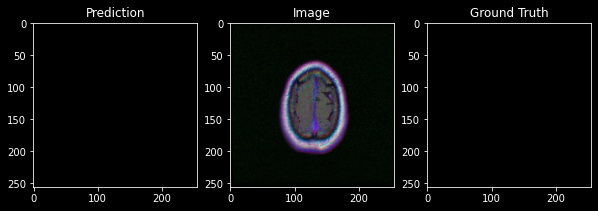

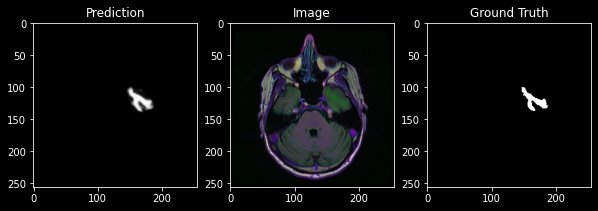

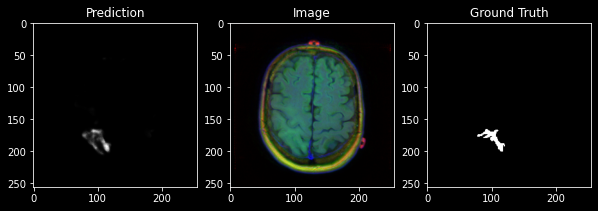

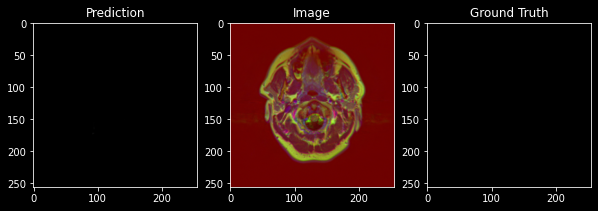

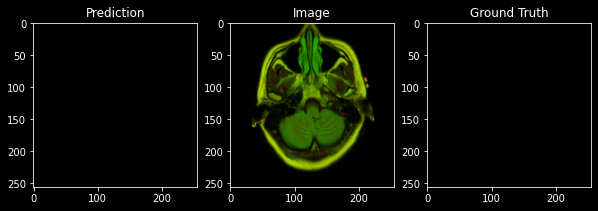

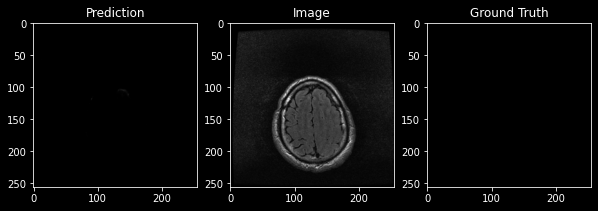

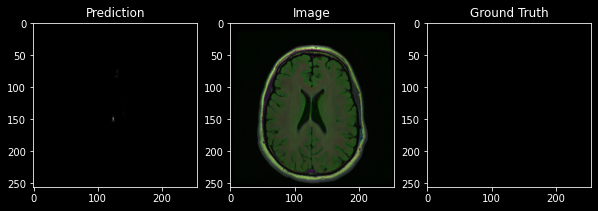

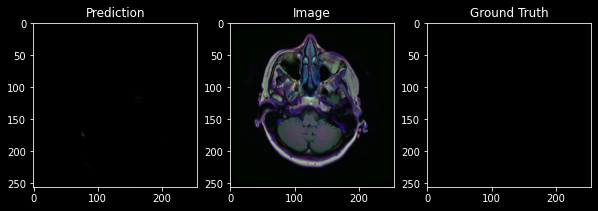

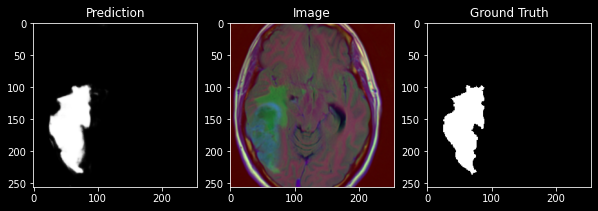

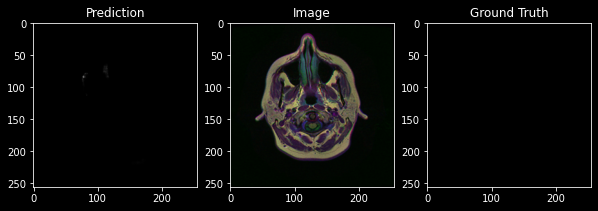

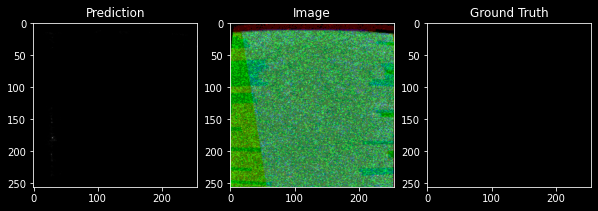

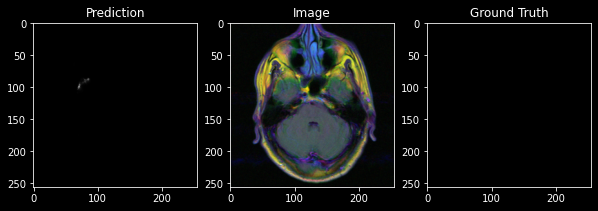

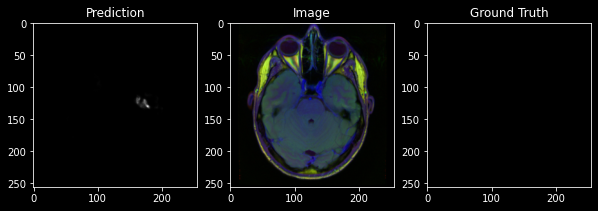

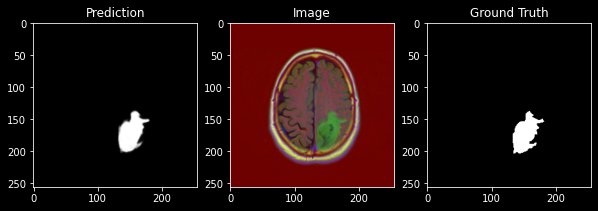

In [73]:
for i in range(20):
  x, y=next(iter(valid_data)) 
  inte=randint(0,9)
  show_img(inte)

In [26]:
from keras.models import load_model
mo=load_model('/content/drive/MyDrive/brain_tumor1_segm.h5', {'iou':iou})

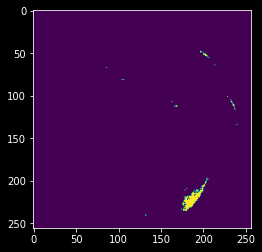

In [66]:
ima=plt.imread('/content/TCGA_CS_6188_20010812_1.tif')


plt.imshow(np.squeeze(mo(np.expand_dims(ima, axis=0))))


Prediction

In [ ]:
from random import randint
randint(0,10)

4

In [ ]:
plt.imshow(y[7])